# Modeling - First Pass

## Setup

### Installs, Packages, Seeds

In [1]:
# %pip install efficientnet_pytorch
%pip install torch
%pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
# from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

In [3]:
# Set Seeds
seed = 99 # go Aaron Judge!
np.random.seed(seed)
torch.cuda.manual_seed(seed)


# Logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

### Mount to Google drive to connect to data

In [93]:
# drive.mount('/drive') 
# %cd /drive/MyDrive/W210 - Capstone/

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/.shortcut-targets-by-id/1oLqejM9KnDiIgUupEGkxGM3_vdqboxlI/W210 - Capstone


In [94]:
# %ls Data/

 archive/                      diverse_stanford/           kaggle/
'Data Classification.gsheet'   diverse_stanford_resized/   problems.csv
 data_dictionary.csv           full_data.csv               problems.gsheet
 data_dictionary.gsheet        ISIC_2018/                  UCI/
 dermnet/                      ISIC_2020/


In [4]:
# data_dir = './Data/'
HOME = '/home/ec2-user/SageMaker/teledermatologyAI_capstone'

## Data

### Load in full_csv which has all of the image paths

In [96]:

# exclude = ['subcutaneous-t-cell-lymphoma', 
# 'foreign-body-granuloma',
# 'morphea', 
# 'dermatomyositis', 
# 'graft-vs-host-disease']

In [42]:
split = 'split_2'
cl = 'label_0'

In [69]:
dev_state = False
dev_sample = 15000

data = pd.read_csv(HOME + '/full_data.csv', index_col = 0).rename(columns = {'duplicated': 'duplicate', 'class':'label_0'})
data = data[data['label_0'] != 'Autoimmue Disorder']
data['label_idx'] = pd.Categorical(data[cl]).codes
small_data = data.sample(n = dev_sample, random_state = seed)
data.rename(columns = {'dataset':'split_0', split:'dataset'}, inplace = True)




In [44]:
if dev_state:
  data = small_data

### Get our final train and test sets

In [96]:
train_df = data[data.dataset == 'train'].reset_index(drop = True)
val_df = data[data.dataset == 'val'].reset_index(drop = True)
test_df = data[data.dataset == 'test'].reset_index(drop = True)

In [101]:
# logging.info("df train"+str(df_train.shape))
# logging.info("df val"+str(df_val.shape))

## Modeling

## Setup

In [99]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [100]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
#         model_ft = models.densenet121(pretrained=use_pretrained)
        model_ft = models.densenet201(pretrained=use_pretrained)
        print(type(model_ft))
        print(feature_extract)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        
    elif model_name == 'efficientnet':
        model_ft = EfficientNet.from_pretrained('efficientnet-b7',num_classes=num_classes)
        set_parameter_requires_grad(model_ft, feature_extract)

#         # Handle the primary net
#         num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 600

    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft, input_size

Set up the GPU

In [101]:
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

GPU Type: Tesla T4
GPU Count: 1


In [102]:
# len(data[cl].unique())
len(data.label.unique())

5

In [103]:
# See notes in ln 498-500: https://github.com/abajaj25/MNIST-Skin-Cancer-with-Jetson/blob/main/notebooks/Final_Model/modeling-images-only-efficient.py
# resnet,vgg,densenet,inception
model_name = 'resnet' # 'efficientnet'
# num_classes = len(data[cl].unique())
num_classes = len(data.label.unique())
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# # Define the device:
device = torch.device('cuda:0')
# # Put the model on the device:
model = model_ft.to(device)

Transforms

In [107]:
# torch.cuda.empty_cache()

In [108]:
# # using torch vision 'transforms'
# train_transform = transforms.Compose([
#                                         transforms.Resize((input_size,input_size)),
#                                     #   transforms.RandomHorizontalFlip(),
#                                     #   transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
#                                     #   transforms.RandomCrop(size=(input_size,input_size)),
# #                                       transforms.RandomInvert(), transforms.RandomPosterize(bits=2),
# #                                       transforms.RandomAdjustSharpness(sharpness_factor=2),
# #                                       transforms.RandomSolarize(threshold=192.0),
# #                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
#                                         transforms.ToTensor(), 
#                                     #   transforms.Normalize(norm_mean, norm_std)
#                                       ])
# # define the transformation of the val images.
# val_transform = transforms.Compose([
#                                     transforms.Resize((input_size,input_size)), 
#                                     transforms.ToTensor(),
#                                     # transforms.Normalize(norm_mean, norm_std)
#                                     ])

In [104]:
# using torch vision 'transforms'
train_transform = transforms.Compose([
                                        transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                    #   transforms.RandomHorizontalFlip(),
                                    #   transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                    #   transforms.RandomCrop(size=(input_size,input_size)),
#                                       transforms.RandomInvert(), transforms.RandomPosterize(bits=2),
#                                       transforms.RandomAdjustSharpness(sharpness_factor=2),
#                                       transforms.RandomSolarize(threshold=192.0),
#                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                      ])
# define the transformation of the val images. also used for test
val_transform = transforms.Compose([
                                        transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])

Pytorch Data Loader

In [77]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index]).convert('RGB')
        
        y = torch.tensor(int(self.df['label_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [78]:
# Only selecting the columns we need from train and val

In [79]:
# Image.open(train['path'][0])

In [80]:
model_cols = ['path', cl, 'label_idx']

In [81]:
model_cols

['path', 'label_0', 'label_idx']

In [54]:
# next(iter(train_loader))

In [82]:
train_df = train_df[model_cols].reset_index(drop = True)
val_df = val_df[model_cols].reset_index(drop = True)
test_df = test_df[model_cols].reset_index(drop = True)

In [83]:
training_set = HAM10000(train_df, transform = train_transform)
train_loader = DataLoader(training_set, batch_size= 64, 
                          shuffle=True, num_workers=24)

val_set = HAM10000(val_df, transform = val_transform)
val_loader = DataLoader(val_set, batch_size= 64, 
                          shuffle=False, num_workers=24)

test_set = HAM10000(test_df, transform = val_transform)
test_loader = DataLoader(test_set, batch_size= 64, 
                          shuffle=False, num_workers=24)


In [84]:
# Set model params
optimizer = optim.SGD(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss().to(device)

Class to Track metrics during training

In [85]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Define train function

In [86]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)

    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
#         if (i + 1) % 1 == 0:
            print(f'[epoch {epoch}], [iter {i+1} of {len(train_loader)}],[train loss {train_loss.avg:.5f}], [train acc {train_acc.avg:.5f}]')
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg
    print('finished train data load')

Define val function

In [87]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print(f'[epoch {epoch}], [val loss {val_loss.avg:.5f}], [val acc {val_acc.avg:.5f}]')
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [88]:
def test(test_loader, model):
    model.eval()
    true_labels = []
    predictions_out = []

    test_loss = AverageMeter()
    test_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            # Save test output
            predictions_out.append(prediction.cpu().numpy())
            true_labels.append(labels.cpu().numpy())

            test_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            test_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print(f'[test loss {test_loss.avg:.5f}], [test acc {test_acc.avg:.5f}]')
    print('------------------------------------------------------------')
    return test_loss.avg, test_acc.avg, predictions_out, true_labels

Run the model

In [89]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


## Train Sequence

In [90]:
model_name = 'resnet_split2_3e_2'
epoch_num = 3
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
print("Starting Training")
total_since = time.time()
for epoch in range(1, epoch_num+1):

    # timing
    since = time.time()

    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model, f'{HOME}/model/{model_name}.pt')
    
    time_elapsed = time.time() - since

    print('\nEPOCH', epoch, ":")
    print('*****************************************************')
    print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
    print('*****************************************************')
    # print(logging.info('*****************************************************'))
    # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
    # print(logging.info('*****************************************************'))

total_time_elapsed = time.time() - total_since
print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 399],[train loss 1.06642], [train acc 0.57766]
[epoch 1], [iter 200 of 399],[train loss 0.98232], [train acc 0.60742]
[epoch 1], [iter 300 of 399],[train loss 0.93686], [train acc 0.62406]
------------------------------------------------------------
[epoch 1], [val loss 0.81004], [val acc 0.66984]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 4m 6s
best record: [epoch 1], [val loss 0.81004], [val acc 0.66984]
*****************************************************
[epoch 2], [iter 100 of 399],[train loss 0.79106], [train acc 0.67547]
[epoch 2], [iter 200 of 399],[train loss 0.78667], [train acc 0.67695]
[epoch 2], [iter 300 of 399],[train loss 0.77941], [train acc 0.67875]
------------------------------------------------------------
[epoch 2], [val loss 0.75611], [val acc 0.68606]
------------------------------------------------------------

EPOCH 2 :
****

In [122]:
# model_name = 'resnet_split6_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'{HOME}/model/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 407],[train loss 1.02624], [train acc 0.55844]
[epoch 1], [iter 200 of 407],[train loss 0.93912], [train acc 0.59344]
[epoch 1], [iter 300 of 407],[train loss 0.89546], [train acc 0.61354]
[epoch 1], [iter 400 of 407],[train loss 0.86916], [train acc 0.62281]
------------------------------------------------------------
[epoch 1], [val loss 0.77504], [val acc 0.65644]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 6m 24s
best record: [epoch 1], [val loss 0.77504], [val acc 0.65644]
*****************************************************
[epoch 2], [iter 100 of 407],[train loss 0.76852], [train acc 0.66734]
[epoch 2], [iter 200 of 407],[train loss 0.75025], [train acc 0.67555]
[epoch 2], [iter 300 of 407],[train loss 0.74472], [train acc 0.67708]
[epoch 2], [iter 400 of 407],[train loss 0.74002], [train acc 0.67805]
-------------------------------------------

#### Previous Runs

In [ ]:
# model_name = 'resnet_split1_3e_2'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 673],[train loss 1.07625], [train acc 0.59188]
[epoch 1], [iter 200 of 673],[train loss 0.90003], [train acc 0.66984]
[epoch 1], [iter 300 of 673],[train loss 0.81836], [train acc 0.70297]
[epoch 1], [iter 400 of 673],[train loss 0.76176], [train acc 0.72340]
[epoch 1], [iter 500 of 673],[train loss 0.72130], [train acc 0.73769]
[epoch 1], [iter 600 of 673],[train loss 0.69296], [train acc 0.74628]
------------------------------------------------------------
[epoch 1], [val loss 0.50842], [val acc 0.81475]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 20m 51s
best record: [epoch 1], [val loss 0.50842], [val acc 0.81475]
*****************************************************
[epoch 2], [iter 100 of 673],[train loss 0.52767], [train acc 0.79797]
[epoch 2], [iter 200 of 673],[train loss 0.51501], [train acc 0.80391]
[epoch 2], [iter 300 of 673],[train loss 0

In [ ]:
# model_name = 'resnet_split1_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 658],[train loss 0.96839], [train acc 0.62906]
[epoch 1], [iter 200 of 658],[train loss 0.80823], [train acc 0.69703]
[epoch 1], [iter 300 of 658],[train loss 0.73678], [train acc 0.72479]
[epoch 1], [iter 400 of 658],[train loss 0.68474], [train acc 0.74422]
[epoch 1], [iter 500 of 658],[train loss 0.65381], [train acc 0.75503]
[epoch 1], [iter 600 of 658],[train loss 0.62744], [train acc 0.76375]
------------------------------------------------------------
[epoch 1], [val loss 0.44100], [val acc 0.83620]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 20m 10s
best record: [epoch 1], [val loss 0.44100], [val acc 0.83620]
*****************************************************
[epoch 2], [iter 100 of 658],[train loss 0.45512], [train acc 0.82016]
[epoch 2], [iter 200 of 658],[train loss 0.44669], [train acc 0.82359]
[epoch 2], [iter 300 of 658],[train loss 0

In [ ]:
# model_name = 'resnet_split3_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

In [ ]:
# model_name = 'resnet_15k_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

In [ ]:
# model_name = 'model_resnet_full'
# epoch_num = 5
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

In [ ]:
best_val_acc

0.8642676767676767

In [ ]:
# model_name = 'resnet_split2_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

In [27]:
# model_name = 'resnet_split4_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 413],[train loss 1.12460], [train acc 0.53844]
[epoch 1], [iter 200 of 413],[train loss 1.04662], [train acc 0.57508]
[epoch 1], [iter 300 of 413],[train loss 1.00262], [train acc 0.59214]
[epoch 1], [iter 400 of 413],[train loss 0.97493], [train acc 0.60191]
------------------------------------------------------------
[epoch 1], [val loss 0.86524], [val acc 0.64597]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 8m 24s
best record: [epoch 1], [val loss 0.86524], [val acc 0.64597]
*****************************************************
[epoch 2], [iter 100 of 413],[train loss 0.85078], [train acc 0.65031]
[epoch 2], [iter 200 of 413],[train loss 0.83847], [train acc 0.65703]
[epoch 2], [iter 300 of 413],[train loss 0.83400], [train acc 0.65781]
[epoch 2], [iter 400 of 413],[train loss 0.82715], [train acc 0.66059]
-------------------------------------------

In [77]:
# model_name = 'resnet_split5_3e'
# epoch_num = 3
# best_val_acc = 0
# total_loss_val, total_acc_val = [],[]
# print("Starting Training")
# total_since = time.time()
# for epoch in range(1, epoch_num+1):

#     # timing
#     since = time.time()

#     loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)

#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model, f'./Models/{model_name}.pt')
    
#     time_elapsed = time.time() - since

#     print('\nEPOCH', epoch, ":")
#     print('*****************************************************')
#     print('Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]')
#     print('*****************************************************')
#     # print(logging.info('*****************************************************'))
#     # print(logging.info(f'best record: [epoch {epoch}], [val loss {loss_val:.5f}], [val acc {acc_val:.5f}]'))
#     # print(logging.info('*****************************************************'))

# total_time_elapsed = time.time() - total_since
# print('\nTotal run Complete in {:.0f}m {:.0f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))

Starting Training
[epoch 1], [iter 100 of 407],[train loss 1.11664], [train acc 0.55016]
[epoch 1], [iter 200 of 407],[train loss 1.04299], [train acc 0.57742]
[epoch 1], [iter 300 of 407],[train loss 0.99161], [train acc 0.59771]
[epoch 1], [iter 400 of 407],[train loss 0.95636], [train acc 0.61234]
------------------------------------------------------------
[epoch 1], [val loss 0.85869], [val acc 0.64691]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 6m 25s
best record: [epoch 1], [val loss 0.85869], [val acc 0.64691]
*****************************************************
[epoch 2], [iter 100 of 407],[train loss 0.84339], [train acc 0.65844]
[epoch 2], [iter 200 of 407],[train loss 0.81449], [train acc 0.66906]
[epoch 2], [iter 300 of 407],[train loss 0.80659], [train acc 0.67370]
[epoch 2], [iter 400 of 407],[train loss 0.79864], [train acc 0.67578]
-------------------------------------------

## Test/Eval

In [28]:
# model_name = 'model_resnet_full'

In [ ]:

# # model_in = torch.load(f'./Models/{model_name}.pth')
# model.load_state_dict(torch.load(f'./Models/{model_name}.pth'))

In [91]:
# model_name = 'resnet_split2_3e'
model_name

'resnet_split2_3e_2'

In [94]:
loss_test, acc_test, preds, labs = test(test_loader, model_in)

------------------------------------------------------------
[test loss 2.68484], [test acc 0.39618]
------------------------------------------------------------


In [93]:
# torch.save(model, './Models/test.pt')
# model_in = torch.load('./Models/model_resnet_full.pt')
model_in = torch.load(f'./model/{model_name}.pt')

In [67]:
loss_test, acc_test, preds, labs = test(test_loader, model_in)

------------------------------------------------------------
[test loss 2.81385], [test acc 0.39634]
------------------------------------------------------------


In [125]:
loss_test, acc_test, preds, labs = test(test_loader, model_in)

------------------------------------------------------------
[test loss 0.71659], [test acc 0.68443]
------------------------------------------------------------


In [31]:
true_labels = np.array(list(itertools.chain(*labs)))
predictions = np.array(list(itertools.chain(*preds)))

In [32]:
correct = (true_labels == predictions.flatten())
accur = correct.sum() / correct.size
accur

0.6973456433929602

In [83]:
model_name

'resnet_split5_3e'

In [33]:
labels_idx = np.sort(data.label_idx.unique())
label_map = data[[cl, 'label_idx']].drop_duplicates().sort_values('label_idx')
label_dict = dict(zip(label_map.label_idx, label_map[cl]))

In [34]:
labs = pd.Series(true_labels).map(label_dict)
preds = pd.Series(predictions.flatten()).map(label_dict)
labels = pd.Series(labels_idx).map(label_dict)

In [35]:
pred_df = pd.concat([labs, 
           preds, 
           pd.Series(true_labels), 
           pd.Series(predictions.flatten())], axis = 1)\
           .rename(columns = {0:'lab', 1: 'pred', 2: 'lab_idx', 3: 'pred_idx'})

In [36]:
len(labs)

3466

In [1]:
model_name

NameError: ignored

In [131]:
pred_df.to_pickle(f'./Models/{model_name}_preds.pkl')

In [43]:
d = pd.read_pickle(f'./Models/{model_name}_preds.pkl')

In [44]:
d

,lab,pred,lab_idx,pred_idx
0,Benign Marking or Mole,Benign Marking or Mole,0,0
1,Benign Marking or Mole,Benign Marking or Mole,0,0
2,Benign Marking or Mole,Benign Marking or Mole,0,0
3,Benign Marking or Mole,Benign Marking or Mole,0,0
4,Benign Marking or Mole,Benign Marking or Mole,0,0
...,...,...,...,...
3519,Potentially Malignant Skin Tumors,"Toxin, Fungal, Bug, Viral, or Bacterial Infect...",2,3
3520,Potentially Malignant Skin Tumors,Benign Marking or Mole,2,0
3521,Potentially Malignant Skin Tumors,Benign Marking or Mole,2,0
3522,Potentially Malignant Skin Tumors,"Toxin, Fungal, Bug, Viral, or Bacterial Infect...",2,3


In [ ]:
d.labs

AttributeError: ignored

In [ ]:
# c_matrix = confusion_matrix(labs, preds, normalize = 'true')
# plt.title("Confusion matrix")
# sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=labels, yticklabels=labels, fmt='.1%', cbar=True)
# plt.xlabel('predictions')
# plt.ylabel('true labels')
# plt.show()

In [37]:
def plot_confusion(labels, predictions, normalize = True): 
    
    if normalize:
        norm = 'true'
        fmt = '.1%'
    else: 
        norm = 'false'
        fmt = 'g'

    labs_unique = np.sort(labels.unique())

    c_matrix = confusion_matrix(labels, predictions, normalize = norm)
    plt.title("Confusion matrix")
    sns.heatmap(c_matrix, cmap='Blues', annot=True, 
                xticklabels=labs_unique, yticklabels=labs_unique, 
                fmt=fmt, cbar=True)
    plt.xlabel('predictions')
    plt.ylabel('true labels')
    plt.show()

6108

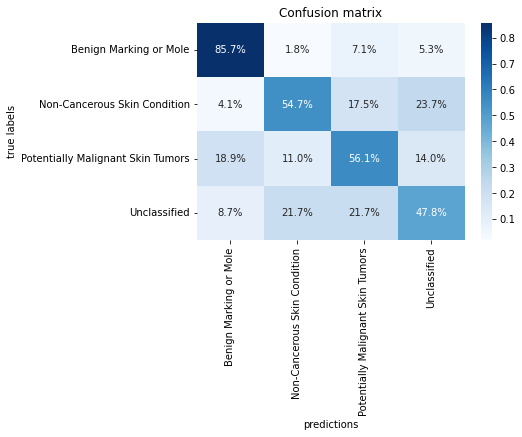

In [38]:
plot_confusion(labs, preds, True)